In [10]:
from PIL import Image
import numpy as np

def load_image(location, target_size=None):
  """
  provide a location and output numpy image
  """
  img = Image.open(location)
  if target_size == None:
    return np.array(img)
  else:
    return np.array(img.resize(target_size))

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import io
import base64
from IPython.display import HTML

def plot_image_grid(images, num_rows=1):
  n = len(images)
  num_cols = np.ceil(n/num_rows)
  fig,axes = plt.subplots(ncols=int(num_cols),nrows=int(num_rows))
  axes = axes.flatten()
  fig.set_size_inches((15,15))
  for i,image in enumerate(images):
      axes[i].imshow(image)

def place_video(location):
  video = io.open(location, 'r+b').read()
  encoded = base64.b64encode(video)
  return HTML(data='''<video alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''.format(encoded.decode('ascii')))

In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import vgg19

In [13]:
#from google.colab import files
#uploaded = files.upload()

Saving starry_night.jpg to starry_night (1).jpg


In [14]:
content_loc = './bridge.jpeg'
style_loc = './starry_night.jpg'

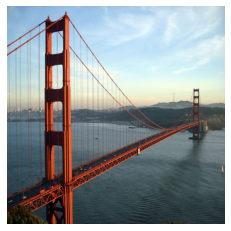

In [15]:
content_img = load_image(content_loc, target_size=(512, 512))
style_img = load_image(style_loc, target_size=(512, 512))
plt.axis('off')
plt.imshow(content_img)

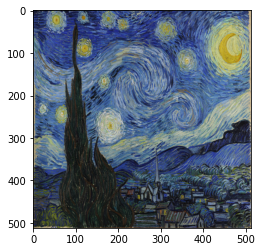

In [16]:
plt.imshow(style_img)

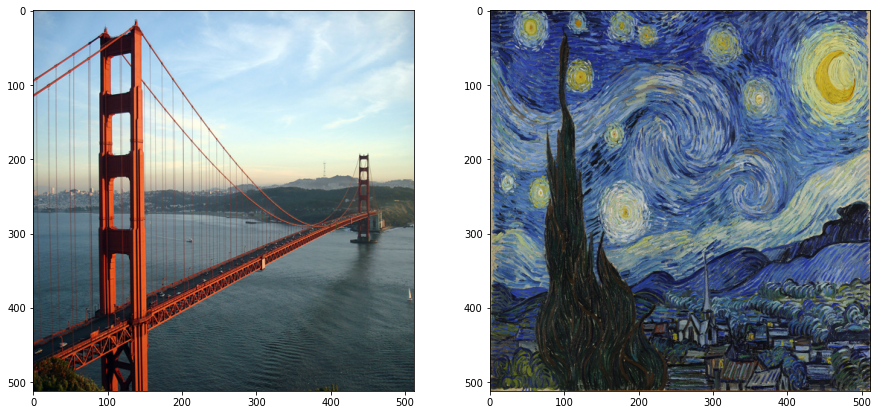

In [17]:
plot_image_grid([content_img, style_img])

In [18]:
base_model = vgg19.VGG19(include_top=False, weights='imagenet')

80150528/80134624 [==============================] - 1s 0us/step


In [19]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [20]:
CONTENT_LAYERS = ['block5_conv2']
OUTPUT_LAYERS = ['block4_conv1',
                'block4_conv2',
                'block4_conv3', 
                'block4_conv4']

In [21]:
def make_model(include_full=False, input_shape=None):
  if include_full:
      base_model = vgg19.VGG19(include_top=True, weights="imagenet")
      return base_model      
  if input_shape != None:
      base_model = vgg19.VGG19(include_top=False, input_shape=input_shape, weights="imagenet")
  else:
      base_model = vgg19.VGG19(include_top=False, weights="imagenet")
  base_model.trainable = False
  content_layers = CONTENT_LAYERS
  style_layers = OUTPUT_LAYERS
  output_layers = [base_model.get_layer(layer).output for layer in (content_layers+style_layers)]
  return tf.keras.models.Model(base_model.input, output_layers)

In [22]:
content_img_noised = content_img
content_img_noised = content_img_noised.astype("float32")

In [23]:
processed_style_img = vgg19.preprocess_input(np.expand_dims(style_img, axis=0))
processed_content_img = vgg19.preprocess_input(np.expand_dims(content_img, axis=0))

In [24]:
VGG_BIASES = vgg19.preprocess_input((np.zeros((3))).astype("float32"))

In [25]:
def deprocess(processed_img):
  unprocessed_img = processed_img - VGG_BIASES
  unprocessed_img = tf.unstack(unprocessed_img, axis=-1)
  unprocessed_img = tf.stack([unprocessed_img[2], unprocessed_img[1], unprocessed_img[0]], axis=-1)
  return unprocessed_img

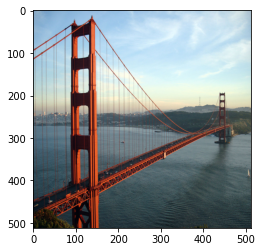

In [26]:
plt.imshow(np.round(deprocess(processed_content_img)[0])/255)

In [27]:
base_model = make_model()

In [28]:
content_outputs = base_model(processed_content_img)
style_outputs = base_model(processed_style_img)

In [29]:
content_img_content = content_outputs[0]
style_img_content = style_outputs[0]

In [30]:
def get_content_loss(new_image_content, base_image_content):
  return np.mean(np.square(new_image_content - base_image_content))

In [31]:
def get_gram_matrix(output):
  first_style_layer = output
  A = tf.reshape(first_style_layer, (-1, first_style_layer.shape[-1]))
  n = A.shape[0]
  gram_matrix = tf.matmul(A, A, transpose_a = True)
  n = gram_matrix.shape[0]
  return gram_matrix/tf.cast(n, "float32"), n

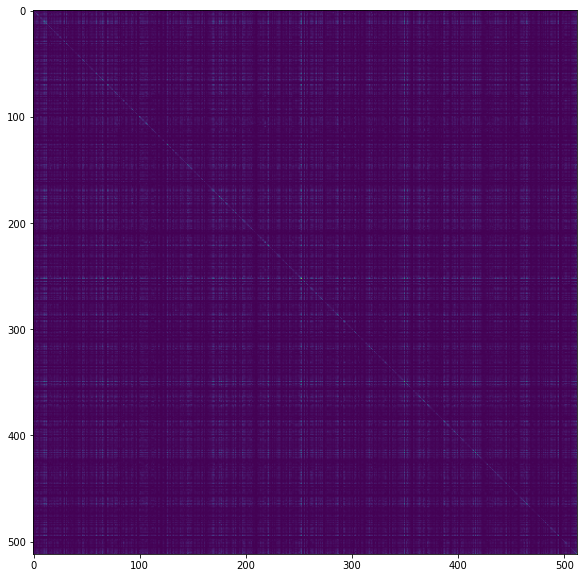

In [32]:
gram_matrix, N = get_gram_matrix(style_outputs[2])
plt.figure(figsize=(10, 10))
plt.imshow(np.array(gram_matrix))

In [33]:
def get_style_loss(new_image_style, base_style):
  new_style_gram, gram_num_height = get_gram_matrix(new_image_style)
  base_style_gram, gram_num_height2 = get_gram_matrix(base_style)
  assert gram_num_height == gram_num_height2
  gram_num_features = new_style_gram.shape[0]
  loss = tf.reduce_sum(tf.square(base_style_gram - new_style_gram)/(4*(gram_num_height**2)*(gram_num_features
                                                                                           **2)))
  return loss

In [34]:
def get_total_loss(new_image_output, base_content_image_output, base_style_image_output, alpha = 0.999):
  new_image_styles = new_image_output[len(CONTENT_LAYERS):]
  base_image_styles = base_style_image_output[len(CONTENT_LAYERS):]
  style_loss = 0
  N = len(new_image_styles)
  for i in range(N):
    style_loss += get_style_loss(new_image_styles[i], base_image_styles[i])

  new_image_contents = new_image_output[:len(CONTENT_LAYERS)]
  base_image_contents = base_content_image_output[:len(CONTENT_LAYERS)]
  content_loss = 0
  N = len(new_image_contents)
  for i in range(N):
    content_loss += get_content_loss(new_image_contents[i], base_image_contents[i])/N

  return (1-alpha)*style_loss + alpha*content_loss

In [35]:
get_total_loss(style_outputs, content_outputs, style_outputs)

<tf.Tensor: shape=(), dtype=float32, numpy=4539.9863>

In [36]:
base_style_outputs = base_model(processed_style_img)

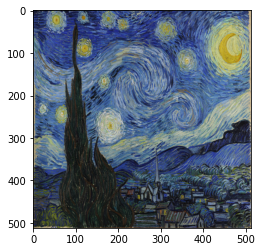

In [37]:
plt.imshow(deprocess(processed_style_img)[0]/255)

In [38]:
base_content_output = base_model(processed_content_img)

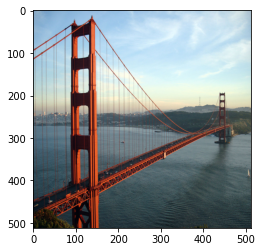

In [39]:
plt.imshow(deprocess(processed_content_img)[0]/255)

In [40]:
processed_content_var = tf.Variable(processed_content_img + tf.random.normal(processed_content_img.shape))

In [41]:
optimizer = tf.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-2)

In [42]:
from IPython.display import display, clear_output

In [43]:
images = []
losses = []

In [44]:
i = 0
best_loss = float('inf')
min_vals = VGG_BIASES
max_vals = 255+VGG_BIASES
for i in range(200):
  with tf.GradientTape() as tape:
    tape.watch(processed_content_var)
    content_var_outputs = base_model(processed_content_var)
    loss = get_total_loss(content_var_outputs, base_content_output, base_style_outputs, alpha = 0.97)
    grad = tape.gradient(loss, processed_content_var)
    losses.append(loss)
    optimizer.apply_gradients(zip([grad], [processed_content_var]))
    clipped = tf.clip_by_value(processed_content_var, min_vals, max_vals)
    processed_content_var.assign(clipped)
    if i%2 == 0:
      images.append(deprocess(processed_content_var))
    if loss < best_loss:
      best_image = processed_content_var
      best_loss = loss
    display(loss)
    clear_output(wait = True)

<tf.Tensor: shape=(), dtype=float32, numpy=4533.336>

In [45]:
deprocessed_best_image = deprocess(best_image)

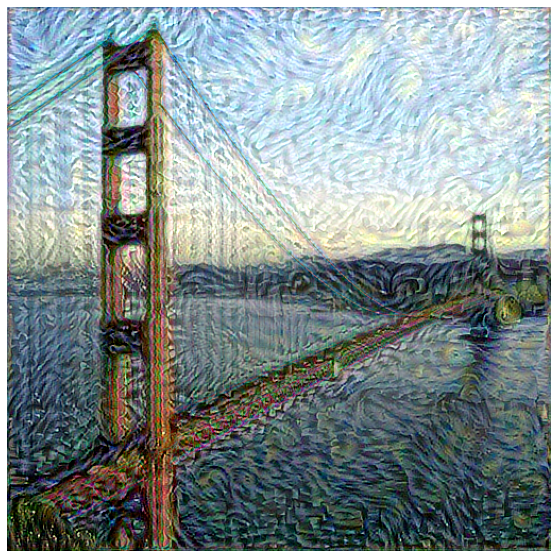

In [46]:
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(deprocessed_best_image[0]/255)
plt.savefig('contentImageWithArtStyle.png')

In [47]:
from matplotlib.animation import FuncAnimation

In [48]:
fig, ax = plt.subplots(figsize=(10, 10))
def update(i):
  im_normed = images[i].numpy().reshape((512, 512, 3))/255
  ax.imshow(im_normed)
  ax.set_title("Loss: {}".format(losses[i]), fontsize=20)
  ax.set_axis_off()
anim = FuncAnimation(fig, update, frames=np.arange(0, len(images)), interval=50)
anim.save('style_transfer.mp4', dpi=80, writer='ffmpeg')
plt.close()

In [49]:
import importlib

In [50]:
place_video('style_transfer.mp4')

In [51]:
loss = get_total_loss(content_var_outputs, base_content_output, style_outputs)
tf.image.total_variation(best_image).numpy()

array([30073446.], dtype=float32)